In [4]:
import torch
import torch.nn as nn 
import torch.optim as optim
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [2]:
# Henon Map
def Henon(x,a = 1.4, b = 0.3):
    
    xnp1 = [1 - a*x[0]**2 + x[1], b*x[0]]
    
    return xnp1

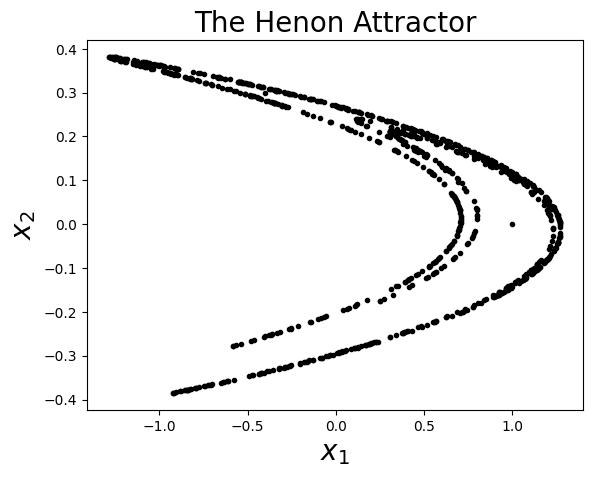

In [78]:
# Generate Henon Data

# Henon parameters
a = 1.4
b = 0.3 # Text uses b = 0.01 or b = 0.3 

# Initializations
N = 1001
x = np.zeros((N,2))
x[0] = [1, 0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n in range(1,N):
    x[n] = Henon(x[n-1], a, b)

# Plot Henon Trajectories
fig = plt.figure()
plt.plot(x[:,0],x[:,1],'k.') 
plt.title('The Henon Attractor', fontsize = 20)
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

for j in range(forward_iters): 
    xnforward.append(torch.tensor(x[j:-forward_iters+j], dtype=torch.float32).to(device))

In [61]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=4, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        # Input is two-dimensional - each component of the Henon output
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        # Activation function
        self.relu = nn.ReLU()

        # Append hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer,num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        # Output is 2D - next step of Henon map
        self.output_layer = nn.Linear(num_neurons_per_layer, 2)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        # Forward pass through layers
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

In [7]:
def compute_loss(model, xnforward, steps):
    loss = 0
    
    for s in range(steps):
        if s == 0:
            xpred = model(xnforward[0])
        else:
            xpred = model(xpred)
        
        xnp1 = xnforward[s+1]
        
        loss += torch.mean( torch.square( xpred - xnp1 ) )/steps

    return loss

In [ ]:
# Initialize model aka tilde u
model = NeuralNetwork().to(device)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# Learning rate schedule
lr_schedule = [1e-2, 1e-3, 1e-4]
def get_lr(epoch):
    if epoch < 1000:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]
    
# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr_schedule[0])

steps = 4

# Number of training epochs
N = 10000
hist = []

In [64]:
# Start timer 
t0 = time()

for i in range(N+1):
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    # Reset gradient of optimizer to 0
    optimizer.zero_grad()

    # Compute loss
    loss = compute_loss(model, xnforward, steps)
    loss.backward()

    # Perform gradient descent step
    optimizer.step()

    # Append current loss to hist
    hist.append(loss.item())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss.item()))

        # Implementing early stopping
        if loss.item() < 1e-5:
            break

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.75809759e-01
It 00050: loss = 1.49698053e-02
It 00100: loss = 6.82653952e-03
It 00150: loss = 3.73374345e-03
It 00200: loss = 1.20328343e-03
It 00250: loss = 1.17841950e-02
It 00300: loss = 4.32454469e-03
It 00350: loss = 5.30040497e-03
It 00400: loss = 1.09820045e-03
It 00450: loss = 4.12760116e-03
It 00500: loss = 2.11725617e-03
It 00550: loss = 1.77099253e-03
It 00600: loss = 1.27683254e-03
It 00650: loss = 1.26978743e-03
It 00700: loss = 2.17195181e-03
It 00750: loss = 1.97092444e-03
It 00800: loss = 6.92695961e-04
It 00850: loss = 2.26601027e-03
It 00900: loss = 2.91587261e-04
It 00950: loss = 3.90650355e-04
It 01000: loss = 1.82522472e-03
It 01050: loss = 1.63856952e-04
It 01100: loss = 1.43796802e-04
It 01150: loss = 1.34458402e-04
It 01200: loss = 1.26914092e-04
It 01250: loss = 1.20431185e-04
It 01300: loss = 1.15259652e-04
It 01350: loss = 1.09264685e-04
It 01400: loss = 1.03251354e-04
It 01450: loss = 9.98078103e-05
It 01500: loss = 9.71122063e-05
It 01550

In [66]:
x

array([[ 1.        ,  0.        ],
       [-0.4       ,  0.3       ],
       [ 1.076     , -0.12      ],
       ...,
       [ 0.66952804, -0.0770068 ],
       [ 0.29541829,  0.20085841],
       [ 1.07867766,  0.08862549]])

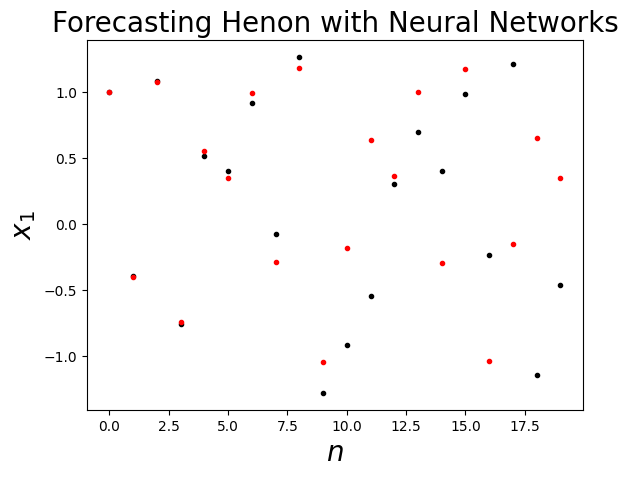

In [77]:
# Use Trained Model to Forecast
M = 101

xpred = torch.zeros((M,2))
xpred[0] = torch.tensor(x[0,:], dtype=torch.float32)

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
# Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:20,0].detach(),'k.') 
plt.plot(x[:20,0],'r.') 
plt.title('Forecasting Henon with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20);

In [70]:
model

NeuralNetwork(
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=20, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
# Load and view saved models
import tf2onnx
import tensorflow as tf
from onnx2pytorch import ConvertModel

loaded_model = tf.keras.models.load_model('../Henon_models/Henon_step=3_b=0_3')
onnx_model, _ = tf2onnx.convert.from_keras(loaded_model)
pytorch_model = ConvertModel(onnx_model)

# Check loss on training data
loss = compute_loss(model, xnforward, steps)
print('loss on training data = ', loss.item())

loss on training data =  3.475221456028521e-05
